In [1]:
# set up libraries + backend
from qiskit.tools.jupyter import * 
from qiskit import IBMQ
from qiskit import assemble
import numpy as np
import matplotlib.pyplot as plt
from qiskit import pulse
from qiskit.pulse import pulse_lib
from qiskit.pulse import Play
from qiskit.tools.monitor import job_monitor
from scipy.optimize import curve_fit
from scipy.interpolate import splrep, sproot, splev

%config InlineBackend.figure_format = 'svg' # cleans up backend

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support OpenPulse"

# conversion factors
GHz = 1.0e9 
MHz = 1.0e6
kHz = 1.0e3
ms = 1.0e-3
us = 1.0e-6
ns = 1.0e-9 
scale_factor = 1e-14 

qubit = 0 # ground state qubit
dt = backend_config.dt # backend time-step

# Get backend qubit freq
backend_defaults = backend.defaults()
qubit_props_dict = backend.properties().qubit_property(0)
rough_cavity_freq = backend_defaults.meas_freq_est[qubit]

# assign measurement map
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"
qubit_meas_group = backend_config.meas_map[meas_map_idx]
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=qubit_meas_group)

# assign experiment channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

# define for convenience
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [2]:
# Define measurement, acquisition parameters
meas_amp = 0.0
acq_samp_us = 0.05
meas_sigma_us = 0.01
meas_risefall_us = 0.01

acq_samp = get_closest_multiple_of_16(acq_samp_us * us/dt)
meas_sigma = get_closest_multiple_of_16(meas_sigma_us * us/dt)
meas_risefall = get_closest_multiple_of_16(meas_risefall_us * us/dt)
meas_pulse = pulse_lib.gaussian_square(duration=acq_samp, amp=meas_amp, sigma=meas_sigma, risefall=meas_risefall)

# Make measurement schedule
meas_schedule = pulse.Schedule(name="Measurement")
meas_schedule += Play(meas_pulse, meas_chan)
meas_schedule += pulse.Acquire(duration=acq_samp, 
                               channel=[pulse.AcquireChannel(i) for i in qubit_meas_group],
                               mem_slot=[pulse.MemorySlot(i) for i in qubit_meas_group])
acq_pulse = pulse.Acquire(duration=acq_samp, 
                               channel=[pulse.AcquireChannel(i) for i in qubit_meas_group],
                               mem_slot=[pulse.MemorySlot(i) for i in qubit_meas_group])

# Design cavity pulse
cav_dur_us = 3.0
cav_amp = 1.0
cav_dur = get_closest_multiple_of_16(cav_dur_us * us/dt)
cavity_pulse = pulse_lib.gaussian_square(duration=cav_dur, amp=cav_amp, 
                                    sigma=meas_sigma, risefall=meas_risefall)

In [3]:
# Define data fit function
def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params, maxfev=5000)
    y_fit = function(x_values, *fitparams)
    return fitparams, y_fit

# Extract data from job
def job_data(job):
    # extract + normalize results
    job_results = job.result(timeout=120)
    values = []
    for i in range(len(job_results.results)):
        values.append(job_results.get_memory(i)[qubit]*scale_factor)
    return values

In [10]:
# Run job based on max time of observed decay, retrieve results and return them
def get_kappa_data(time_max_us):
    # Linewidth experiment parameters
    num_times=50
    times_us = np.linspace(0, time_max_us, num_times, endpoint=True) # Times of acquisition during decay
    delay_times_dt = times_us * us / dt
    kappa_schedules = [] # separate schedule for each delay time
    for delay in delay_times_dt:
        this_schedule = pulse.Schedule(name=f"T1 delay = {delay * dt/us} us")
        this_schedule += Play(cavity_pulse, meas_chan)
        this_schedule += meas_schedule << int(delay)
        kappa_schedules.append(this_schedule)
    
    # assemble schedules
    num_shots = 256
    kappa_experiment = assemble(kappa_schedules,
                         backend=backend, 
                         meas_level=1,
                         meas_return='avg',
                         shots=num_shots,
                         schedule_los=[{meas_chan: rough_cavity_freq}] * len(kappa_schedules))

    kappa_job = backend.run(kappa_experiment) # job contains acquisition windows for all delay times
    print(kappa_job.job_id())
    job_monitor(kappa_job)
    
    kappa_data = job_data(kappa_job) # Returns job results as decay plot
    
    return kappa_data

5f163098e5ddf1001a1c1fee
Job Status: job has successfully run


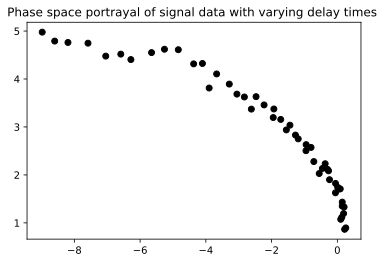

In [11]:
max_time = 10 # Sample max acquisition time
data = get_kappa_data(max_time) 

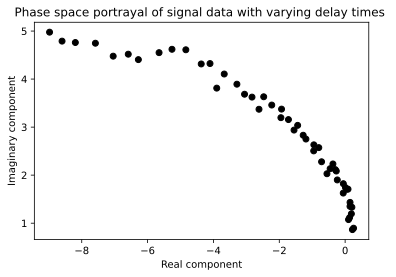

In [12]:
for point in data:
    plt.scatter(np.real(point), np.imag(point), color='black') # Plot quadratures
plt.xlabel("Real component")
plt.ylabel("Imaginary component")
plt.title("Phase space portrayal of signal data with increasing delay time")
plt.show()

# delay time increases from left to right (see below to know why)

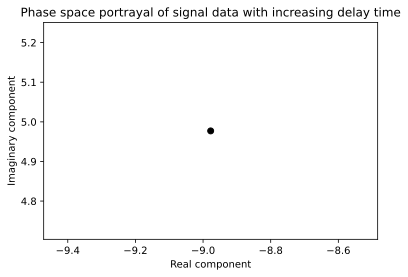

In [14]:
# verify that top left point is first delay time (t=0)
plt.scatter(np.real(data[0]), np.imag(data[0]), color='black')
plt.xlabel("Real component")
plt.ylabel("Imaginary component")
plt.title("Phase space portrayal of signal data with increasing delay time")
plt.show()